# 2自由度制御

以下のシステムを想定します。

<img src='two_degrees_of_freedom_control_with_d_bd.drawio.svg'>

入力$r$、$d$と出力$y$の関係は以下のようになります。

\begin{eqnarray}
u_{ff} &=& \frac{F(s)}{P(s)} r \\
u_{fb} &=& K(s)( F(s)r - y ) \\
y &=& P(s)( u_{ff} + u_{fb} + d ) \\
  &=& F(s) r + \frac{P(s)}{1+K(s)P(s)}d
\end{eqnarray}

## 目標値応答

$d=0$としたときの$r$から$y$への伝達関数が目標値応答となります。
$F(s)$目標値応答そのものの動特性となります。


## 外乱応答

$r=0$としたときの$d$から$y$への伝達関数が外乱応答となります。
FB制御器$K(s)$の設計に応じて外乱を抑制することができます。


## 補足:低次な制御対象に対するFF補償

$P(s)$に以下のような伝達関数のシステムを想定します。

\begin{equation*}
P(s) = \frac{\omega_0}{s+\omega_0} \frac{1}{s}
\end{equation*}

また、（欲張って）$F(s)=1$とします。（$F(s)$に相当する計算は目標軌道生成に託し、その結果として$r$が得られているという想定。）

すると、コントローラ上へ

\begin{equation*}
\frac{F(s)}{P(s)} = \frac{s+\omega_0}{\omega_0}s = \frac{s^2}{\omega_0} + s
\end{equation*}

を実装することになります。


何かと敬遠されがちな微分計算が入っていますが、目標軌道$r$を連続空間で導出している場合は導出時にその微分値$\dot{r},\ddot{r}$も併せて（離散化の影響を受けない精度で）導出できる場合があります。

仮に$r$に合わせて$\dot{r},\ddot{r}$も利用できると仮定すると、




\begin{eqnarray}
u_{ff} = \frac{F(s)}{P(s)} r = \left\{ \frac{s^2}{\omega_0} + s \right\} r = \frac{1}{\omega_0}\ddot{r} + \dot{r}
\end{eqnarray}

とすることができます。

仮に$r$を位置の目標軌道とすると、その1階微分や2階微分は速度や加速度に相当し、目標軌道として位置・速度・加速度を利用することで2次程度の制御対象であれば制御周期毎の微分処理を実施せずにFF補償の計算が可能になります。


## シミュレーション

$P(s)$が角周波数$\omega_0$[rad/s]をカットオフ周波数に持つ1次遅れ系と積分器からなると想定します。
\begin{equation*}
P(s) = \frac{\omega_0}{s+\omega_0} \frac{1}{s}
\end{equation*}


$K(s)$として以下を想定します。(PI制御)
\begin{equation*}
K(s) = G_p + \frac{G_i}{s}
\end{equation*}


$r$はステップ信号を時定数2[s]の単純移動平均とさらに時定数1[s]の単純移動平均した信号を想定します。

$d$は2.5[s]から振幅10のステップ信号を想定します。

コントローラへの実装を意識してlsim()を使わずにシミュレーションを実装します。
（lsim()使うとy=1\*rとなるだけなので。）

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import *

In [15]:
# シミュレーション環境設定
control_cycle = 1e-3
simulation_time = 5

# 制御対象設定
omega_0 = 1

# FB制御器設定
G_p = 10
G_i = 1

# 目標軌道設定
start_time = 1
amplitude = 10   # 振幅
sma1_td = 2       # 移動平均時定数1
sma2_td = 1       # 移動平均時定数2

# 外乱設定
d_start_time = 2.5
d_amplitude = 10


In [16]:
# シミュレーション時間リスト生成
list_time = np.arange(0,simulation_time,control_cycle)

# 制御対象システム生成
P_tf_con = tf([omega_0], [1, omega_0, 0])
P_ss_con = tf2ss( P_tf_con )
P_ss_dig = c2d(P_ss_con, control_cycle, method='tustin')

# FB制御器の生成
K_tf_con = tf([ G_p, G_i ], [ 1, 0 ])
K_ss_con = tf2ss( K_tf_con )
K_ss_dig = c2d(K_ss_con, control_cycle, method='tustin')

# 目標軌道生成
sma1_window_size = int( sma1_td / control_cycle )
sma1_window = np.ones(sma1_window_size)/sma1_window_size
sma2_window_size = int( sma2_td / control_cycle )
sma2_window = np.ones(sma2_window_size)/sma2_window_size
step = amplitude * (start_time < list_time)
step_sma1 = np.convolve(step,sma1_window,mode="full")
step_sma2 = np.convolve(step_sma1,sma2_window,mode="full")
dot_step_sma2 = np.diff( step_sma2 )
ddot_step_sma2 = np.diff( dot_step_sma2 )
list_r = step_sma2[0:len(list_time)]
list_dot_r = dot_step_sma2[0:len(list_time)] / control_cycle
list_ddot_r = ddot_step_sma2[0:len(list_time)] / control_cycle / control_cycle

# 外乱生成
list_d = d_amplitude * ( (d_start_time < list_time) )
list_d = d_amplitude * ( (d_start_time < list_time) & ( list_time < 3) )

In [39]:
class ExecutableSSDigSystem:
        
    def __init__(self,ss_sys,x0,y0):
        self.__x = x0
        self.__dx = x0 # 計算の都合上の代入
        self.__ss_sys = ss_sys
        self.__y = y0
    
    def execute(self,u):
        # 現状態更新
        self.__x = self.__dx
        
        # 次状態計算
        self.__dx = self.__ss_sys.A * self.__x + self.__ss_sys.B * u

        # 出力計算
        self.__y = self.__ss_sys.C * self.__x + self.__ss_sys.D * u
        
        return (self.__y,self.__x)

    def getx(self):
        return self.__x
    
    def setx(self,val):
        pass
    
    def gety(self):
        return self.__y
    
    def sety(self,val):
        pass

    x = property(getx,setx)
#     dx = 0
    y = property(gety,sety)
#     ss_sys = 0 # 離散状態空間システム


In [17]:
# 初期値
P_x = np.matrix([[0],[0]])
P_dot_x = np.matrix([[0],[0]])
P_y = 0

K_x = np.matrix([[0]])
K_dot_x = np.matrix([[0]])

# シミュレーション格納用リスト
list_y = np.empty(0)
list_u_ff = np.empty(0)
list_u_fb = np.empty(0)

# シミュレーション(FF無し)
for (r,dot_r,ddot_r,d) in zip(list_r,list_dot_r,list_ddot_r,list_d):
    
    # FB制御器計算
    K_dot_x = K_ss_dig.A * K_x + K_ss_dig.B * ( r - P_y )
    u_fb = K_ss_dig.C * K_x + K_ss_dig.D * ( r - P_y )
    
    # 次状態計算
    P_dot_x = P_ss_dig.A * P_x + P_ss_dig.B * ( u_fb + d )
    
    # 出力計算
    P_y = P_ss_dig.C * P_x + P_ss_dig.D * ( u_fb + d )
    
    # 現状態更新
    K_x = K_dot_x
    P_x = P_dot_x
    
    # 結果の格納
    list_u_fb = np.append( list_u_fb,u_fb )
    list_y = np.append( list_y,P_y )


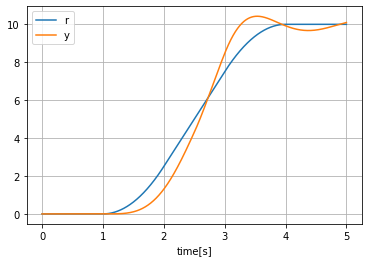

In [18]:
plt.figure()
plt.plot( list_time, list_r, label="r" )
plt.plot( list_time, list_y, label="y" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()


In [19]:
# 初期値
P_x = np.matrix([[0],[0]])
P_dot_x = np.matrix([[0],[0]])
P_y = 0

K_x = np.matrix([[0]])
K_dot_x = np.matrix([[0]])

# シミュレーション格納用リスト
list_y = np.empty(0)
list_u_ff = np.empty(0)
list_u_fb = np.empty(0)

# シミュレーション
for (r,dot_r,ddot_r,d) in zip(list_r,list_dot_r,list_ddot_r,list_d):
    
    # FF制御器計算
    u_ff = ddot_r / omega_0 + dot_r
    
    # FB制御器計算
    K_dot_x = K_ss_dig.A * K_x + K_ss_dig.B * ( r - P_y )
    u_fb = K_ss_dig.C * K_x + K_ss_dig.D * ( r - P_y )
    
    # 次状態計算
    P_dot_x = P_ss_dig.A * P_x + P_ss_dig.B * ( u_ff + u_fb + d )
    
    # 出力計算
    P_y = P_ss_dig.C * P_x + P_ss_dig.D * ( u_ff + u_fb + d )
    
    # 現状態更新
    K_x = K_dot_x
    P_x = P_dot_x
    
    # 結果の格納
    list_u_ff = np.append( list_u_ff,u_ff )
    list_u_fb = np.append( list_u_fb,u_fb )
    list_y = np.append( list_y,P_y )


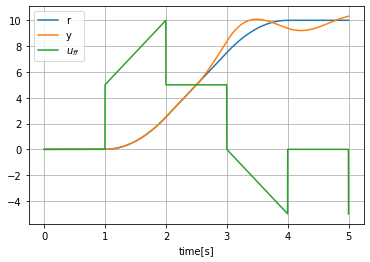

In [20]:
plt.figure()
plt.plot( list_time, list_r, label="r" )
plt.plot( list_time, list_y, label="y" )
plt.plot( list_time, list_u_ff, label=r"$u_{ff}$" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()


In [42]:
# 初期化
P = ExecutableSSDigSystem(P_ss_dig,np.matrix([[0],[0]]),0)
K = ExecutableSSDigSystem(K_ss_dig,np.matrix([[0]]),0)

# シミュレーション格納用リスト
list_y = np.empty(0)
list_u_ff = np.empty(0)
list_u_fb = np.empty(0)

# シミュレーション
for (r,dot_r,ddot_r,d) in zip(list_r,list_dot_r,list_ddot_r,list_d):
    
    # FF制御器計算
    u_ff = ddot_r / omega_0 + dot_r
    
    # FB制御器の状態・出力更新
    # 1周期前のPの出力を使っている
    K.execute( r - P.y )
    
    # 制御対象の状態更新
    P.execute( u_ff + K.y + d )
    
    # 結果の格納
    list_u_ff = np.append( list_u_ff,u_ff )
    list_u_fb = np.append( list_u_fb,u_fb )
    list_y = np.append( list_y,P.y )


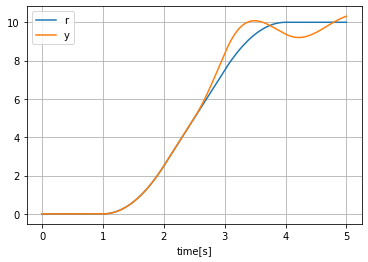

In [43]:
plt.figure()
plt.plot( list_time, list_r, label="r" )
plt.plot( list_time, list_y, label="y" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()
